In [1]:
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (838 kB/s)
Selecting previously unselected package libspatialindex

# Import the relevant packages

In [177]:
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, f1_score


## DISCLAIMER !!


*   As I have lost a fair share amount of my time stuck at the `geopandas` framework installation due to its incompatiblity with Mac M1, I decided to move on to Google Colab to perform the task.

*  The training file for some reason could not be opened without crashing. It keeps returning that that some stored values do not match the json format even I have verified it online. So as to solve this problem, I sliced only a part of the around 20,000 ( 19,996 to be exact) for the training and validation set.

* Despite the smaller dataset, I am certain that my preprocessing methods and other requirements are met.




# Let's start by reading the sliced training data

In [463]:
train_df = gpd.read_file('20k_train.geojson', index_col=0)
print(train_df.shape)

(19996, 15)


In [92]:
train_df.head()

,index,change_type,change_status_date1,change_status_date2,change_status_date3,change_status_date4,change_status_date5,date1,date2,date3,date4,date5,urban_types,geography_types,geometry
0,0,Commercial,Land Cleared,Construction Midway,Construction Done,Construction Done,Construction Done,29-05-2014,13-09-2015,25-02-2017,10-10-2018,19-05-2020,Industrial,"River,Sparse Forest,Grass Land","POLYGON ((116.97563 38.89002, 116.97590 38.890..."
1,1,Commercial,Greenland,Greenland,Construction Done,Construction Done,Construction Done,29-05-2014,13-09-2015,25-02-2017,10-10-2018,19-05-2020,Sparse Urban,"Sparse Forest,Grass Land","POLYGON ((116.97500 38.88969, 116.97524 38.889..."
2,2,Commercial,Land Cleared,Land Cleared,Construction Done,Construction Done,Construction Done,29-05-2014,13-09-2015,25-02-2017,10-10-2018,19-05-2020,Sparse Urban,"Sparse Forest,Grass Land","POLYGON ((116.97519 38.88847, 116.97568 38.888..."
3,3,Commercial,Land Cleared,Land Cleared,Construction Midway,Construction Midway,Construction Done,29-05-2014,13-09-2015,25-02-2017,10-10-2018,19-05-2020,Industrial,"River,Sparse Forest,Grass Land","POLYGON ((116.97630 38.89017, 116.97730 38.890..."
4,4,Commercial,Land Cleared,Land Cleared,Construction Started,Construction Midway,Construction Done,29-05-2014,13-09-2015,25-02-2017,10-10-2018,19-05-2020,Industrial,"River,Sparse Forest,Grass Land","POLYGON ((116.97751 38.89037, 116.97854 38.890..."


Below is the graph showing that distribution of the 6 classes of this sliced dataset. From quick grasp, we see a **very imbalanced dataset** that is likly to affect the classification result.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Residential      0.502851
Commercial       0.352170
Demolition       0.105121
Road             0.038408
Industrial       0.001350
Mega Projects    0.000100
Name: change_type, dtype: float64


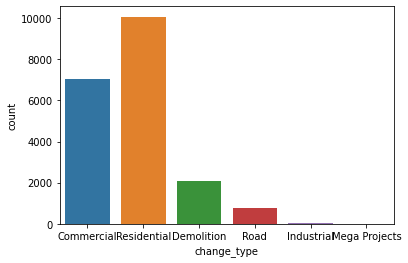

In [221]:
sns.countplot(train_df['change_type'])
print(train_df['change_type'].value_counts(normalize =True))

## FEATURE ENGINEERING 1 
##One hot encoder on `df['urban_types']` and `df['geography_types']`

We can observe that for some particular items, the `df['urban_types']` and `df['geography_types']` can belont to one class, that is 'multil-labeled' item.

To handle this, each item in string is transformed into a list with the delimiter of "," to break the items into a list.

Then each of this list is parsed through the `sklearn.preprocessing.MultiLabelBinarizer` to turn the list string values into encoded numbers

In [223]:
train_df['urban_types'].unique()

array(['Industrial', 'Sparse Urban', 'None', 'Rural', 'Dense Urban',
       'Sparse Urban,Industrial', 'Urban Slum', 'Dense Urban,Industrial',
       'Rural,Industrial', 'Sparse Urban,Dense Urban'], dtype=object)

In [224]:
def get_element_list(elements: str):
    "This function help transform the string into list of items"
    element = elements.split(",")
    return element

In [238]:
#for example
print(get_element_list("River,Sparse Forest,'Grass Land'"))

['River', 'Sparse Forest', "'Grass Land'"]


In [228]:
# We use the lambda function to quickly the transformation of string format into a list
urban_type_list = train_df['urban_types'].apply(lambda x : get_element_list(x) ) 
geography_type_list = train_df['geography_types'].apply(lambda x : get_element_list(x) )

print(urban_type_list[:5])
print()
print(geography_type_list[:5])


0      [Industrial]
1    [Sparse Urban]
2    [Sparse Urban]
3      [Industrial]
4      [Industrial]
Name: urban_types, dtype: object

0    [River, Sparse Forest, Grass Land]
1           [Sparse Forest, Grass Land]
2           [Sparse Forest, Grass Land]
3    [River, Sparse Forest, Grass Land]
4    [River, Sparse Forest, Grass Land]
Name: geography_types, dtype: object


Now that we have test that everything works fine,  we funtionize the whole `feature engineering 1` to return the dataframe of one-hot-encoded of `urban and geography multi labels`

In [229]:
def laberizer(df):
    """
    This function will transform the 'urban' and 'geograpy' multi-labeleld item
    into list, then sending to laberizer to generate one-hot encoder vector
    """
    urban_type_col = df['urban_types']
    geography_col = df['geography_types']

    binarizer = MultiLabelBinarizer() # we call the MultiLabelBinarizer to perform the one-hot-encoder

    urban_type_list = urban_type_col.apply(lambda x : get_element_list(x) ) #This use the function created above list from string
    geography_type_list = geography_col.apply(lambda x : get_element_list(x) )


    urban_df = pd.DataFrame(data = binarizer.fit_transform(urban_type_list), # the each list will be parsed throuth the binarizer to turn into one-hot encoder
                            columns = binarizer.classes_,
                            index= df.index)
    
    geography_df = pd.DataFrame(data = binarizer.fit_transform(geography_type_list),
                            columns = binarizer.classes_,
                            index= df.index)
    
    concat_df =  pd.concat([urban_df, geography_df], axis=1) #The laberized dataframes of 2 columns are stored and then concatenated into one dataframe after this function
    
    return concat_df

Now we create a new dataframe containing all the vectorized features from the `laberizer(df)` function

The resulting features from this transformation is **17**

In [402]:
laberized_df = laberizer(df = train_df)
print(laberized_df.shape)

(19996, 17)


In [403]:
laberized_df.head()

,Dense Urban,Industrial,None,Rural,Sparse Urban,Urban Slum,Barren Land,Coastal,Dense Forest,Desert,Farms,Grass Land,Hills,Lakes,None,River,Sparse Forest
0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1


## FEATURE ENGINEERING 2
## Feature extraction from `dataframe['geometry']`

 The main 2 features we are to extract from the geometric point of view are the `area` and `length` features of each polygon. 
 
The assumption on these two features are that different change types (as our output feature) might be assoicated with these 2. For examples, for mega projects the size should be significantly larger, while the length for 'road' should be relatively larger. 

However, once using the skeleton code to compute these two features  there is a warning message that 'area' are likely incorrect because of geographic CRS.

 After some research, according to https://stackoverflow.com/questions/72073417/userwarning-geometry-is-in-a-geographic-crs-results-from-buffer-are-likely-i, geometric coordinate must be changed to `3857` to represent the meter unit

In [327]:
# this is to show the inital warning after computing the `area` of each polygon

area_df = train_df[['geometry']].area
area_df.head()

<ipython-input-327-ee358865adc1>:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_df = train_df[['geometry']].area


0    1.237159e-06
1    4.701495e-07
2    4.536881e-07
3    2.936349e-07
4    2.905206e-07
dtype: float64

In [326]:
train_df['geometry'].crs # we can see that the original CRS value here 4326

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [328]:
train_df['geometry'].to_crs(crs=3857).area #print the area values for each polygon

0        19696.329229
1         7485.095575
2         7222.892931
3         4674.921704
4         4625.352291
             ...     
19991     9277.218634
19992      347.791658
19993     2567.121478
19994     1783.097894
19995      856.372844
Length: 19996, dtype: float64

In [329]:
train_df['geometry'].to_crs(crs=3857).length #print the length values for each polygon

0        755.370237
1        385.791590
2        380.821486
3        308.690960
4        308.903385
            ...    
19991    477.217792
19992     74.922370
19993    248.087744
19994    174.483445
19995    123.537916
Length: 19996, dtype: float64

Then we functionize the above method so that after calling this function, we will get the concatenated dataframe of geometric features : `area` and `length`

In [348]:
def polygon_extractor(df):
    geometry_col = df['geometry'].to_crs(crs=3857) #make sure we transform CRS to meter unit

    area_df = pd.DataFrame(data = geometry_col.area,
                            columns = ["area"],
                            index= df.index)
    
    length_df = pd.DataFrame(data = geometry_col.length,
                            columns = ["length"],
                            index= df.index)
    
    concat_df =  pd.concat([area_df, length_df], axis=1)
    
    return concat_df



In [405]:
# Show the example of the returned dataframe from calling the polygon_extractor()
polygon_extractor_df = polygon_extractor(train_df)
polygon_extractor_df.head()

,area,length
0,19696.329229,755.370237
1,7485.095575,385.791590
2,7222.892931,380.821486
3,4674.921704,308.690960
4,4625.352291,308.903385


## FEATURE ENGINEERING 3
## Number of days between two consecutive date

In [393]:
date_cols = train_df.columns[7: 12] # extract the columns name of [date1, date2, date3] to the list
end_date_idx = 1
start_date_idx = 0

concat_df = []

# Perform for loop to compute the date difference in absolute unit. As there are 5 days, there is 4 intervals to keep track of
for date_idx in range(4): # range of 4 because of 4 intervals
    train_df[[date_cols[start_date_idx], date_cols[end_date_idx]]] = train_df[[date_cols[start_date_idx], date_cols[end_date_idx]]] .apply(pd.to_datetime) # must transform the string format to pd.datetime for valid computation
    date_diff = pd.DataFrame(np.abs((train_df[date_cols[start_date_idx]] - train_df[date_cols[end_date_idx]]) / np.timedelta64(1, 'D')),
                             columns = [f'datediff_{date_idx+1}'])
    end_date_idx +=1
    start_date_idx +=1
    concat_df.append(date_diff)

Now we turn the test code into a function for later user again.

In [471]:
def compute_date_diff(df):
    date_cols = ['date1', 'date2', 'date3', 'date4', 'date5'] # extract the columns name of [date1, date2, date3] to the list
    end_date_idx = 1
    start_date_idx = 0

    concat_df = []

    # Perform for loop to compute the date difference in absolute unit. As there are 5 days, there is 4 intervals to keep track of
    for date_idx in range(4): # range of 4 because of 4 intervals
        df[[date_cols[start_date_idx], date_cols[end_date_idx]]] = df[[date_cols[start_date_idx], date_cols[end_date_idx]]] .apply(pd.to_datetime) # must transform the string format to pd.datetime for valid computation
        date_diff = pd.DataFrame(np.abs((df[date_cols[start_date_idx]] - df[date_cols[end_date_idx]]) / np.timedelta64(1, 'D')),
                                columns = [f'datediff_{date_idx+1}'])
        end_date_idx +=1
        start_date_idx +=1
        concat_df.append(date_diff)

    return pd.concat(concat_df, axis = 1)

In [472]:
date_diff_df = compute_date_diff(train_df)
date_diff_df.head()

,datediff_1,datediff_2,datediff_3,datediff_4
0,472.0,531.0,592.0,587.0
1,472.0,531.0,592.0,587.0
2,472.0,531.0,592.0,587.0
3,472.0,531.0,592.0,587.0
4,472.0,531.0,592.0,587.0


## Now that we have achieved three feature engineering and extraction, we are going to merge all these 3 dataframes into the main dataset for classificaiton

In [406]:
print(laberized_df.shape, polygon_extractor_df.shape, date_diff_df.shape)

(19996, 17) (19996, 2) (19996, 4)


In [410]:
# let's call the concatenated df as `main_df`
main_df = pd.concat([laberized_df, polygon_extractor_df, date_diff_df ], axis= 1)
print(main_df.shape)
main_df.head()

(19996, 23)


,Dense Urban,Industrial,None,Rural,Sparse Urban,Urban Slum,Barren Land,Coastal,Dense Forest,Desert,...,Lakes,None,River,Sparse Forest,area,length,datediff_1,datediff_2,datediff_3,datediff_4
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,19696.329229,755.370237,472.0,531.0,592.0,587.0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,7485.095575,385.791590,472.0,531.0,592.0,587.0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,7222.892931,380.821486,472.0,531.0,592.0,587.0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,4674.921704,308.690960,472.0,531.0,592.0,587.0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,4625.352291,308.903385,472.0,531.0,592.0,587.0


 # Training the model by splitting the dataset into training and validation set

In [412]:
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}
train_y = train_df['change_type'].apply(lambda x: change_type_map[x])

In [414]:
X_train, X_test, val_train, val_test = train_test_split(main_df, train_y,
                                                    test_size =0.2, random_state=42)

print(X_train.shape, X_test.shape, val_train.shape, val_test.shape)

(15996, 23) (4000, 23) (15996,) (4000,)


## 1st Classfication model: SVM

In [419]:
from sklearn.svm import SVC

svc_classifer = SVC(kernel = 'rbf')
svc_classifer.fit(X_train, val_train)
pred_y = svc_classifer.predict(X_test)

In [420]:
print(classification_report(y_true = val_test,
                      y_pred = pred_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       443
           1       0.75      0.02      0.04       150
           2       0.62      0.84      0.71      1986
           3       0.52      0.48      0.50      1417
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         1

    accuracy                           0.59      4000
   macro avg       0.32      0.22      0.21      4000
weighted avg       0.52      0.59      0.53      4000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2nd: Classfication model: KNearestNeighbors

In [559]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, val_train)
pred_y = neigh.predict(X_test)


print(classification_report(y_true = val_test,
                      y_pred = pred_y))

              precision    recall  f1-score   support

           0       0.31      0.41      0.35       443
           1       0.57      0.45      0.51       150
           2       0.73      0.74      0.74      1986
           3       0.57      0.52      0.55      1417
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         1

    accuracy                           0.61      4000
   macro avg       0.36      0.35      0.36      4000
weighted avg       0.62      0.61      0.62      4000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3rd: Classfication model: Random Forest

In [566]:
from sklearn.ensemble import RandomForestClassifier
rdm_classifier = RandomForestClassifier()
rdm_classifier.fit(X_train, val_train)
pred_y = rdm_classifier.predict(X_test)

print(classification_report(y_true = val_test,
                      y_pred = pred_y))

              precision    recall  f1-score   support

           0       0.49      0.50      0.50       443
           1       0.65      0.53      0.58       150
           2       0.75      0.76      0.76      1986
           3       0.63      0.63      0.63      1417
           4       1.00      0.33      0.50         3
           5       0.00      0.00      0.00         1

    accuracy                           0.68      4000
   macro avg       0.59      0.46      0.49      4000
weighted avg       0.67      0.68      0.67      4000



## We finetune the hyperparameters of RandomForest 
by using `sklearn.model_selection.GridSearchCV` to perform not only the hyperparameters tuning but look at the 10-fold crossvalidation of the model performance

In [431]:
from sklearn.model_selection import GridSearchCV

In [442]:
# Let's declare some of the Random Forest's hyperparametrs for the grid search to reiterate through
param_grid = {
"max_depth": [10, 15,20], 
"max_features": ['sqrt', 'log2']
}

random_forest_classifier =  RandomForestClassifier()
grid_cv_classifier = GridSearchCV(random_forest_classifier, 
                                  param_grid = param_grid,
                                  cv = 10,
                                  scoring = "f1_weighted") #we use the f1-score metric as specified in the instructino

grid_cv_classifier.fit(X_train, val_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 15, 20],
                         'max_features': ['sqrt', 'log2']},
             scoring='f1_weighted')

In [443]:
pd.DataFrame(grid_cv_classifier.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.897056,0.048546,0.033055,0.001654,10,sqrt,"{'max_depth': 10, 'max_features': 'sqrt'}",0.683407,0.673620,0.702472,0.694283,0.688103,0.701395,0.681356,0.691733,0.686032,0.689063,0.689146,0.008403,6
1,0.892609,0.020633,0.032768,0.001688,10,log2,"{'max_depth': 10, 'max_features': 'log2'}",0.686621,0.673579,0.705857,0.701869,0.684198,0.702022,0.675350,0.694616,0.692003,0.687532,0.690365,0.010470,5
2,1.219032,0.098798,0.048857,0.010458,15,sqrt,"{'max_depth': 15, 'max_features': 'sqrt'}",0.710196,0.690971,0.711631,0.699668,0.690011,0.721373,0.697806,0.705700,0.702159,0.708234,0.703775,0.009191,2
3,1.160627,0.027085,0.044833,0.001257,15,log2,"{'max_depth': 15, 'max_features': 'log2'}",0.714021,0.698348,0.712872,0.701393,0.693672,0.714931,0.692831,0.708668,0.704107,0.720212,0.706105,0.008995,1
4,1.284855,0.024126,0.050709,0.001374,20,sqrt,"{'max_depth': 20, 'max_features': 'sqrt'}",0.694711,0.685875,0.710277,0.688245,0.688186,0.714062,0.682876,0.695782,0.691815,0.708912,0.696074,0.010545,3
5,1.433537,0.188765,0.052279,0.005432,20,log2,"{'max_depth': 20, 'max_features': 'log2'}",0.698573,0.681043,0.702863,0.689649,0.684637,0.711570,0.690497,0.693865,0.690574,0.703125,0.694640,0.008865,4


We observed that after the hyperparameters tuning, the best model can achieve slightly better from non-finedtuned model, with the f1 score increasing from *68%* to touching around *70%*

In [569]:
# print the best parameters after using grid search to find the best hyperparameter of the model
grid_cv_classifier.best_params_

{'max_depth': 15, 'max_features': 'log2'}

In [568]:
finetuned_forest_model = RandomForestClassifier(max_depth= 15, max_features= 'log2')
finetuned_forest_model.fit(X_train, val_train)
pred_y = finetuned_forest_model.predict(X_test)

print(classification_report(y_true = val_test,
                      y_pred = pred_y))

              precision    recall  f1-score   support

           0       0.53      0.49      0.51       443
           1       0.70      0.53      0.60       150
           2       0.76      0.79      0.77      1986
           3       0.65      0.65      0.65      1417
           4       1.00      0.33      0.50         3
           5       0.00      0.00      0.00         1

    accuracy                           0.70      4000
   macro avg       0.61      0.46      0.51      4000
weighted avg       0.69      0.70      0.69      4000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---

# Now perform the classifer on the `Test.geojson`

In [498]:
test_df = gpd.read_file('test.geojson', index_col=0)

In [499]:
test_df.head()

,index,change_status_date1,change_status_date2,change_status_date3,change_status_date4,change_status_date5,date1,date2,date3,date4,date5,urban_types,geography_types,geometry
0,0,Prior Construction,Prior Construction,Land Cleared,Land Cleared,Land Cleared,20-11-2014,29-11-2015,16-05-2017,27-10-2018,19-03-2020,None,Barren Land,"POLYGON ((103.97404 36.01415, 103.97448 36.014..."
1,1,Prior Construction,Prior Construction,Land Cleared,Land Cleared,Land Cleared,20-11-2014,29-11-2015,16-05-2017,27-10-2018,19-03-2020,None,Barren Land,"POLYGON ((103.97465 36.01404, 103.97460 36.013..."
2,2,Prior Construction,Prior Construction,Land Cleared,Land Cleared,Land Cleared,20-11-2014,29-11-2015,16-05-2017,27-10-2018,19-03-2020,None,Barren Land,"POLYGON ((103.97492 36.01409, 103.97490 36.014..."
3,3,Prior Construction,Prior Construction,Land Cleared,Construction Done,Construction Done,20-11-2014,29-11-2015,16-05-2017,27-10-2018,19-03-2020,None,Barren Land,"POLYGON ((103.97448 36.01374, 103.97442 36.013..."
4,4,Land Cleared,Land Cleared,Land Cleared,Land Cleared,Land Cleared,20-11-2014,29-11-2015,16-05-2017,27-10-2018,19-03-2020,None,Barren Land,"POLYGON ((103.97462 36.01347, 103.97482 36.013..."


In [462]:
test_df.shape

(121704, 14)

## We perform the 3 feature engineering tasks as discussed above to the test dataset

In [473]:
test_laberize_df = laberizer(test_df) #Feature engineering 1
test_polygon_extractor_df =polygon_extractor(test_df) #Feature engineering 2
test_date_diff_df = compute_date_diff(test_df) #Feature engineering 3


# then create the concatenated datset from the 3 dataframes 
test_X_df = pd.concat([test_laberize_df, test_polygon_extractor_df, test_date_diff_df ], axis = 1)

/usr/local/lib/python3.8/dist-packages/shapely/measurement.py:45: RuntimeWarning: invalid value encountered in area
  return lib.area(geometry, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/measurement.py:187: RuntimeWarning: invalid value encountered in length
  return lib.length(geometry, **kwargs)


In [570]:
print(test_laberize_df.shape)
print(laberized_df.shape)

(121704, 17)
(19996, 17)


In [571]:
test_laberize_df.columns

Index(['Dense Urban', 'Industrial', 'None', 'Rural', 'Sparse Urban',
       'Urban Slum', 'Barren Land', 'Coastal', 'Dense Forest', 'Desert',
       'Farms', 'Grass Land', 'Hills', 'Lakes', 'None', 'River',
       'Sparse Forest'],
      dtype='object')

In [486]:
laberized_df.columns

Index(['Dense Urban', 'Industrial', 'None', 'Rural', 'Sparse Urban',
       'Urban Slum', 'Barren Land', 'Coastal', 'Dense Forest', 'Desert',
       'Farms', 'Grass Land', 'Hills', 'Lakes', 'None', 'River',
       'Sparse Forest'],
      dtype='object')

Above we found out the *mismatch between training and testing* after vectorize the geography and urban types.

 We find that in the test geography types, there is a class 'Snow' that does not exist in our sliced dataset, as a result we must remove this one feature to match the shape size between training dataset and testing dataset

In [489]:
# So we must this particular feature "Snow"
test_laberize_df = test_laberize_df.drop(columns = 'Snow')

In [490]:
# Then we recreate the test_X_df by combining the three dataframes
test_X_df = pd.concat([test_laberize_df, test_polygon_extractor_df, test_date_diff_df ], axis = 1)

In [491]:
test_X_df.head()

,Dense Urban,Industrial,None,Rural,Sparse Urban,Urban Slum,Barren Land,Coastal,Dense Forest,Desert,...,Lakes,None,River,Sparse Forest,area,length,datediff_1,datediff_2,datediff_3,datediff_4
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,856.336625,134.729897,374.0,534.0,529.0,509.0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,2184.504698,234.248978,374.0,534.0,529.0,509.0
2,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,740.522694,146.495899,374.0,534.0,529.0,509.0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1236.129069,171.796278,374.0,534.0,529.0,509.0
4,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1098.852733,137.895207,374.0,534.0,529.0,509.0


In [496]:
# we make sure that the resulting shapes of training and testing are now MATCHED !
test_X_df.shape[1] == X_train.shape[1]

True

## Classificaiton on the test dataset
Now we select the best yet model from finetuned random forest to perform the classfication on the test data

In [573]:
clean_test_X = test_X_df.replace([np.inf, -np.inf], np.nan, inplace=False)
clean_test_X = np.nan_to_num(clean_test_X)
pred_y = finetuned_forest_model.predict(pd.DataFrame(clean_test_X, columns = test_X_df.columns ))

In [574]:
# we want to see how is the distibution of the predicted output class. It is quite in alignment with the training data distribution
# The class 4 and 5 (industrial and mega projects) are severely missed out becasue of the imbalanced training data
for class_index in range(6):
    print(f"The numbe of prediced class {list(change_type_map.keys())[class_index]}: {np.sum(pred_y == class_index)}")

The numbe of prediced class Demolition: 824
The numbe of prediced class Road: 869
The numbe of prediced class Residential: 61126
The numbe of prediced class Commercial: 58884
The numbe of prediced class Industrial: 1
The numbe of prediced class Mega Projects: 0


In [579]:
predicted_df = pd.DataFrame(pred_y, columns = ['predicted_classes'])
predicted_df.head()

,predicted_classes
0,2
1,3
2,2
3,3
4,2


# Save the model prediction output and the model

In [580]:
predicted_df.to_csv('predicted_class.csv')

In [581]:
import joblib

In [582]:
filename = 'finetuned_randomforest.sav'
joblib.dump(finetuned_forest_model, filename)

['finetuned_randomforest.sav']

---

# Ideas for some furhter improvement


** Preprocessing step **
*  Larger dataset: if I can train with more dataset like the real dataset I am supposed to train on, that could help achieve overall model performance
* Imbalanced strategy: undersampling or oversampling or class weight could be performed to adjust the model prediciton probabily on rare classes like Industrial and Mega projects
*  Some other feature engineering: for example apart from date differemce we can possibly look at the overall start to ending time, 
* Data scaling: For continouts variables such as areas, lenght and time interval, the standardization could help achieve the better stability and overall performance


** Model Selection **
* More classifier could be explored like gradient bossting classifier, or even some basic fully connected neural network with different non-linear activation functions could be explored.


## Some final thougth

It has been such a very nerve-wrecking yet exciting experience !!! I definitely would welcome any feedback or  more discussion on this exercise. 

Thank you so much for the opportunity. I hope to hear back from you soon !

